<a href="https://colab.research.google.com/github/Ale10chine/DL-Laboratory/blob/master/nndl_lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2024/25 (6 CFU) - Prof. Michele Rossi, Prof. Jacopo Pegoraro, Dr. Gianmaria Ventura, Dr. Pietro Talli
---


## Lab. 02 - Least Squares with NumPy and PyTorch


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Part 1: Least Squares with NumPy

## Define the true model and generate some noisy samples


Let's define a simple quadratic model

$$
y = a + b * x + c * x^2 + \text{noise}\\
Y=X \beta + \text{noise}\\
X=[1, x, x^2], \quad
\beta =
\begin{bmatrix}
  a\\
  b\\
  c
\end{bmatrix} =
\begin{bmatrix}
  -1.45\\
  1.12\\
  2.3
\end{bmatrix}
$$


In [8]:
# Function to create the polynomial model
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)

    # x^0  x^1  x^2
    # x^0  x^1  x^2
    # x^0  x^1  x^2
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose() # Create a list of vector for each i, then becomes trasponse
    print(x_matrix)
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

In [4]:
# TEST
beta = [-1.45, 1.12, 2.3]
x = np.array([1, 2, 3])
expected_y = np.array([1.97, 9.99, 22.61])
if np.array_equal(poly_model(x, beta, noise_std=0), expected_y):
  print('OK!')
else:
  print('Something is wrong')

[[1 1 1]
 [1 2 4]
 [1 3 9]]
OK!


Generate 10 training points and 10 test points. Add a gaussian noise with zero mean and 0.2 std (set a random seed for reproducible results).

[[1.         0.5507979  0.30337833]
 [1.         0.70814782 0.50147334]
 [1.         0.29090474 0.08462557]
 [1.         0.51082761 0.26094484]
 [1.         0.89294695 0.79735426]
 [1.         0.89629309 0.8033413 ]
 [1.         0.12558531 0.01577167]
 [1.         0.20724288 0.04294961]
 [1.         0.0514672  0.00264887]
 [1.         0.44080984 0.19431332]]
[[-0.14409983]
 [ 0.40107063]
 [-1.19232084]
 [-0.10077547]
 [ 1.560279  ]
 [ 1.74344787]
 [-1.26306288]
 [-1.20003936]
 [-1.49533631]
 [-0.81866781]]
[[-0.14409983  0.40107063 -1.19232084 -0.10077547  1.560279    1.74344787
  -1.26306288 -1.20003936 -1.49533631 -0.81866781]]
[[1.         0.28352508 0.08038647]
 [1.         0.69313792 0.48044017]
 [1.         0.44045372 0.19399948]
 [1.         0.15686774 0.02460749]
 [1.         0.54464902 0.29664255]
 [1.         0.78031476 0.60889113]
 [1.         0.30636353 0.09385861]
 [1.         0.22195788 0.0492653 ]
 [1.         0.38797126 0.1505217 ]
 [1.         0.93638365 0.87681434]]
[

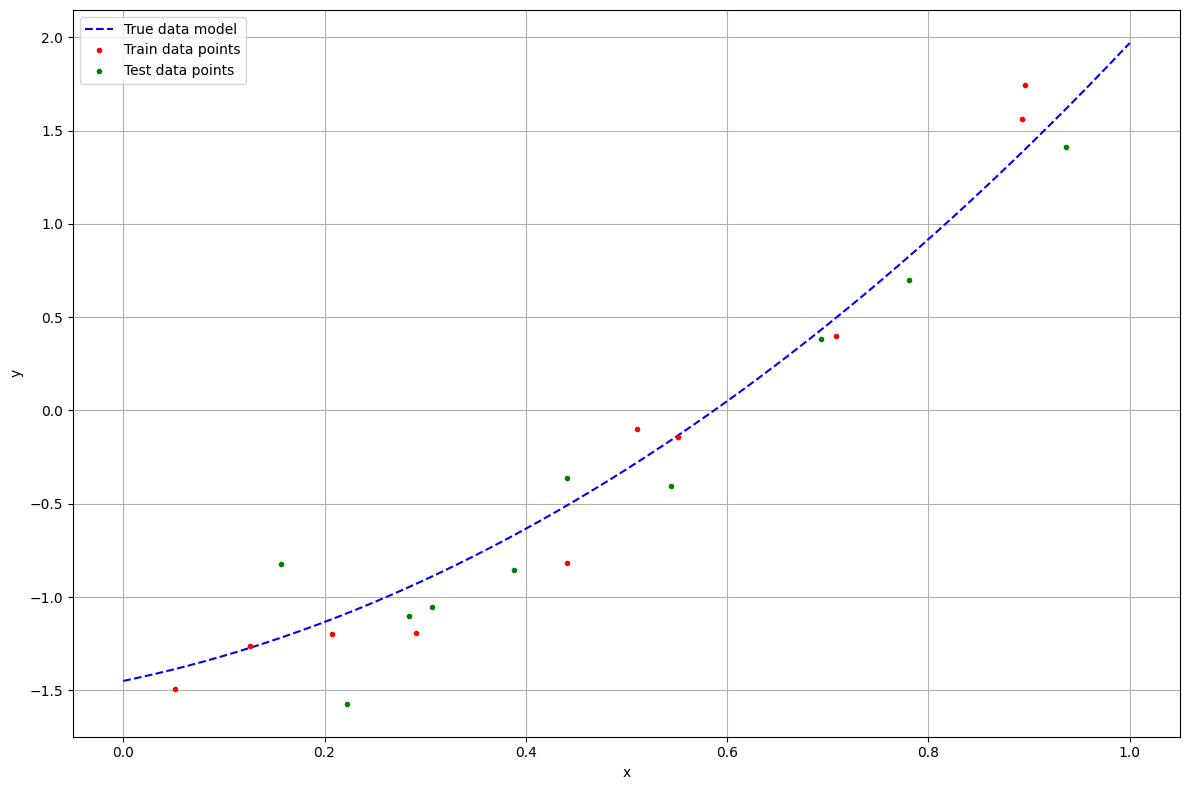

In [34]:
### True parameter values
beta_true = [-1.45, 1.12, 2.3]

### Set random seed
np.random.seed(3)

### Generate 10 train points
num_train_points = 10
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std=0.2)

# NOTE: look also at the next blocks , we need to use the reshape to visualize a vector 1D
# like column or row vector
Y = y_train.reshape(len(y_train), 1)
print(Y)
print(Y.transpose())
#print("Vector t: ", y_train.transpose())
#print("Vector : ", y_train)

### Generate 10 test points
num_test_points = 10
x_test = np.random.rand(num_test_points)
y_test = poly_model(x_test, beta_true, noise_std=0.2)



### Plot-1, 2
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000) # 0 - 1000 with distance 1

# Plot the true data model
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')

# Plot training and test set
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_test, y_test, color='g', ls='', marker='.', label='Test data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Least Squares Algorithm

ORDINARY LEAST SQUARES


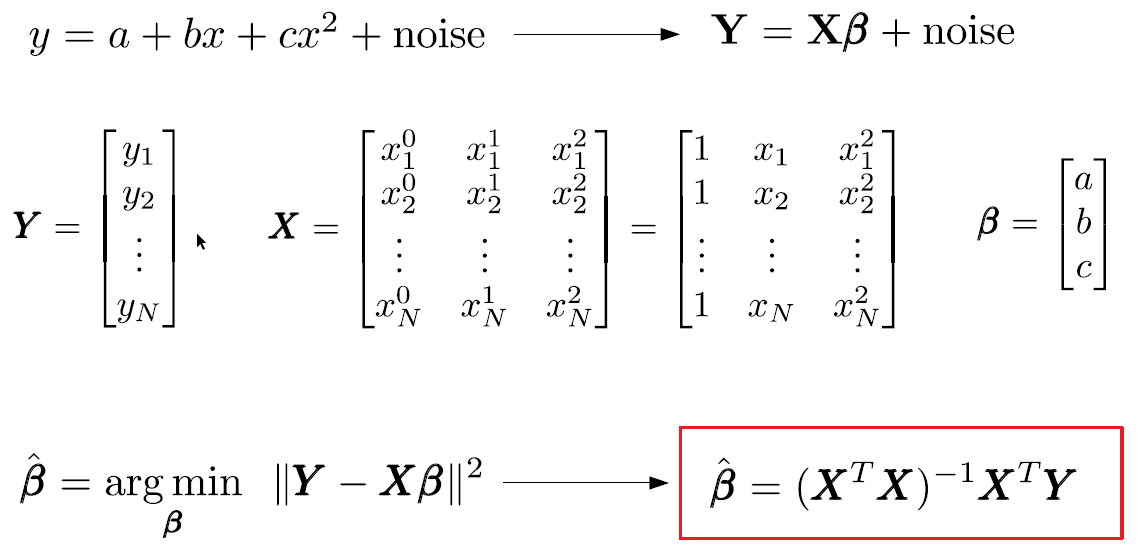

REGULARIZED LEAST SQUARES

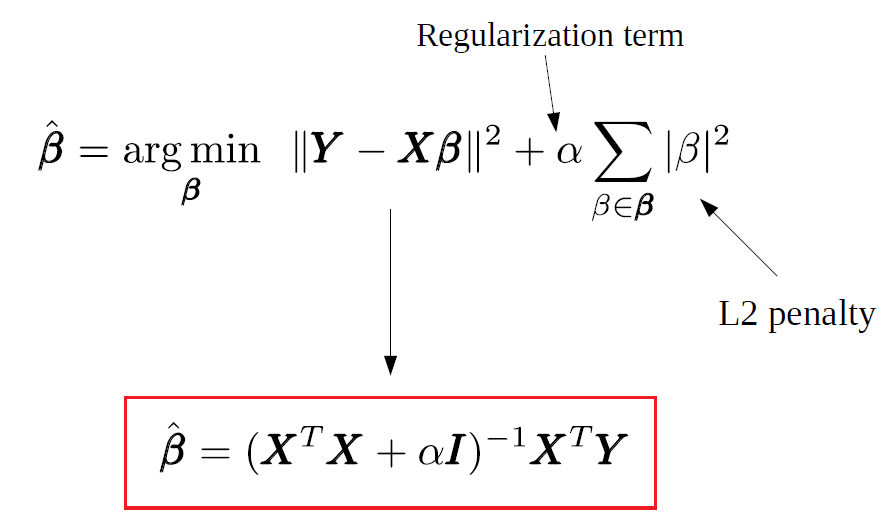

Let's define a function to implement the Regularized Least Square algorithm.

NOTE: OLS is RLS with $\alpha=0$


---


*HINTS*

`np.matmul(x1, x2)` -> Matrix product of two arrays

`np.linalg.inv(a)` -> Compute the inverse of a matrix

`a.transpose()` -> Reverse or permute the axes of an array

`a.squeeze()` -> Remove single-dimensional entries from the shape of an array

`np.identity(n)` -> Return the $n \times  n$ identity array

In [60]:
def least_squares(x, y, pol_order, reg_term):
    """
    Implement the least square algorithm to fit a polynomial function of order "pol_order"
    INPUT
        x: training x data
        y: training y data
        pol_order: order of the fitting polynomial function
        reg_term: regularization term
    OUTPUT
        beta_est: estimated parameter vector
    """

    # Create the Y matrix
    print(y.shape)
    Y = y.reshape(len(y), 1)
    #print(Y.shape) # To do matrix operation in numpy es with transpose we need to reshape the vector in a matrix
    # len(y) x 1 , where the second dimension is like it's as if it didn't exist
      # Create the X matrix
    X = np.array([x**i for i in range(pol_order+1)]).transpose()

    # RLS algorithm

    #print(X.shape[1]) # := dim cols
    #print(X.shape[0]) # := dim rows
    #print(len(X)) # := dim rows

    gram_matrix = np.matmul(X.transpose(),X) + np.eye(X.shape[1])*reg_term # (X^TX + I*reg_term)
    gram_matrix_inv = np.linalg.inv(gram_matrix) # (X^TX + I*reg_term)^-1
    temp = np.matmul(X.transpose(), Y) # (X^T*Y )
    beta_est = np.matmul(gram_matrix_inv, temp)# (X^TX + I*reg_term)^-1 * (X^T*Y )

    return beta_est.squeeze() # Reverse of reshape, if we got a fictitious dim this function will remove it


### Ordinary Least Square (OLS) - No regularization - Model known

Let's suppose that we already know that the order of the underlying polynomial model is 2 (this is a very valuable **prior** information, and rarely happens in real world cases).

In [47]:
### Fit the model
beta_ols = least_squares(x_train, y_train, pol_order=2, reg_term=0)

print('True parameters', beta_true)
print('Inferred parameters (Training)', beta_ols)

(10,)
True parameters [-1.45, 1.12, 2.3]
Inferred parameters (Training) [-1.47163667  0.39838972  3.44032748]


[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]]


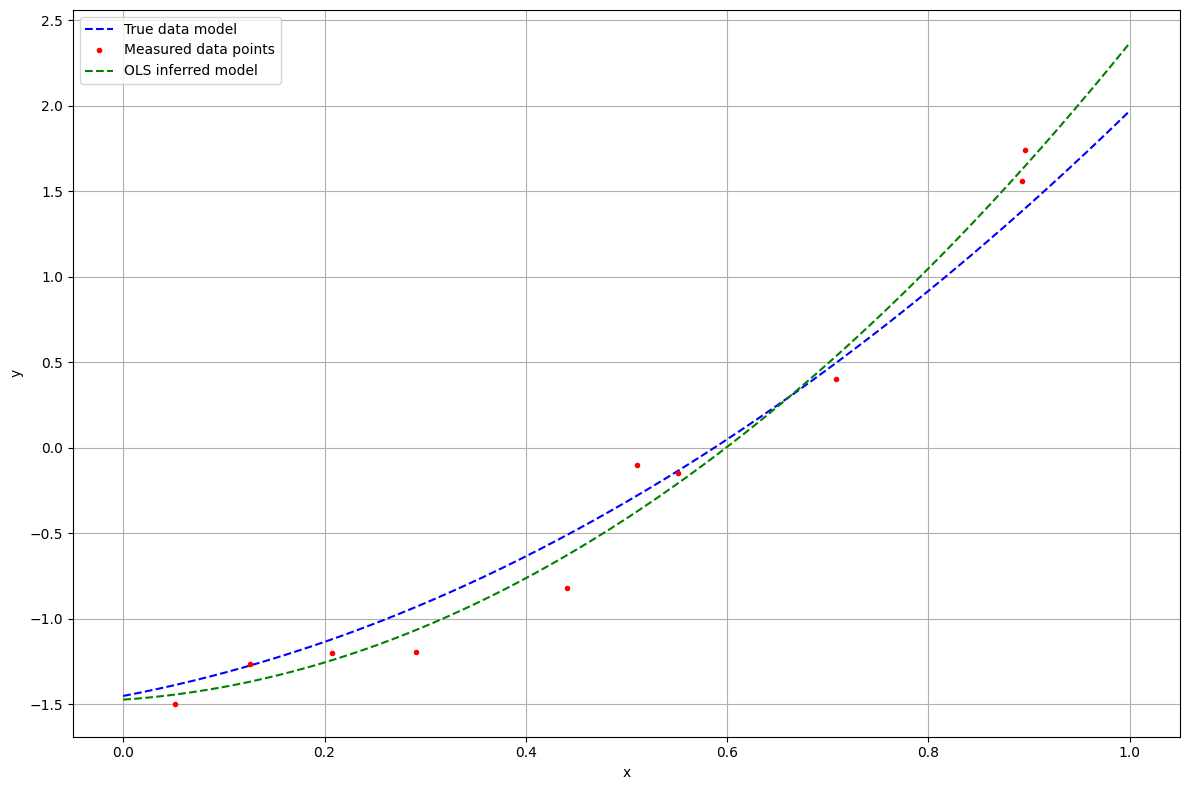

In [48]:

### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Measured data points')
plt.plot(x_highres, poly_model(x_highres, beta_ols), color='g', ls='--', label='OLS inferred model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
### Train and test loss
# Evaluate the average train MSE
y_train_ols = poly_model(x_train, beta_ols)
train_loss = np.mean((y_train_ols - y_train)**2) # Training error L_S(h)
print('Train loss:', train_loss)

# Evaluate the average test loss
y_test_ols = poly_model(x_test, beta_ols)
test_loss = np.mean((y_test_ols - y_test)**2) # Test errror L_D(h)
print('Test loss:', test_loss)

[[1.         0.5507979  0.30337833]
 [1.         0.70814782 0.50147334]
 [1.         0.29090474 0.08462557]
 [1.         0.51082761 0.26094484]
 [1.         0.89294695 0.79735426]
 [1.         0.89629309 0.8033413 ]
 [1.         0.12558531 0.01577167]
 [1.         0.20724288 0.04294961]
 [1.         0.0514672  0.00264887]
 [1.         0.44080984 0.19431332]]
Train loss: 0.01766080007865899
[[1.         0.28352508 0.08038647]
 [1.         0.69313792 0.48044017]
 [1.         0.44045372 0.19399948]
 [1.         0.15686774 0.02460749]
 [1.         0.54464902 0.29664255]
 [1.         0.78031476 0.60889113]
 [1.         0.30636353 0.09385861]
 [1.         0.22195788 0.0492653 ]
 [1.         0.38797126 0.1505217 ]
 [1.         0.93638365 0.87681434]]
Test loss: 0.08031750472826943


As you can see the model is pretty close to the true one, considering the low number of training points.

Any knowledge about the true model is **very** helpful!

### Ordinary Least Square (OLS) - No regularization - Model unknown

Now let's consider a more realistic scenario, where we know nothing about the true model. Since we do not have any information, we can try to fit a polynomial model with order 9.

In [51]:
### Fit the model with a higher order polynomial
beta_ols_ho = least_squares(x_train, y_train, pol_order=9, reg_term=0)

print('True parameters', beta_true)
print('Inferred parameters', beta_ols_ho)

(10,)
True parameters [-1.45, 1.12, 2.3]
Inferred parameters [-1.88474811e+01  7.47168106e+02 -1.19125164e+04  9.69081709e+04
 -4.53210203e+05  1.28448805e+06 -2.23540146e+06  2.32901441e+06
 -1.33048283e+06  3.20009483e+05]


[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06 ... 1.00702808e-21
  1.00803612e-24 1.00904517e-27]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06 ... 1.28899595e-19
  2.58057247e-22 5.16631125e-25]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01 ... 9.86069874e-01
  9.84095760e-01 9.82125598e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01 ... 9.93014000e-01
  9.92019992e-01 9.91026979e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


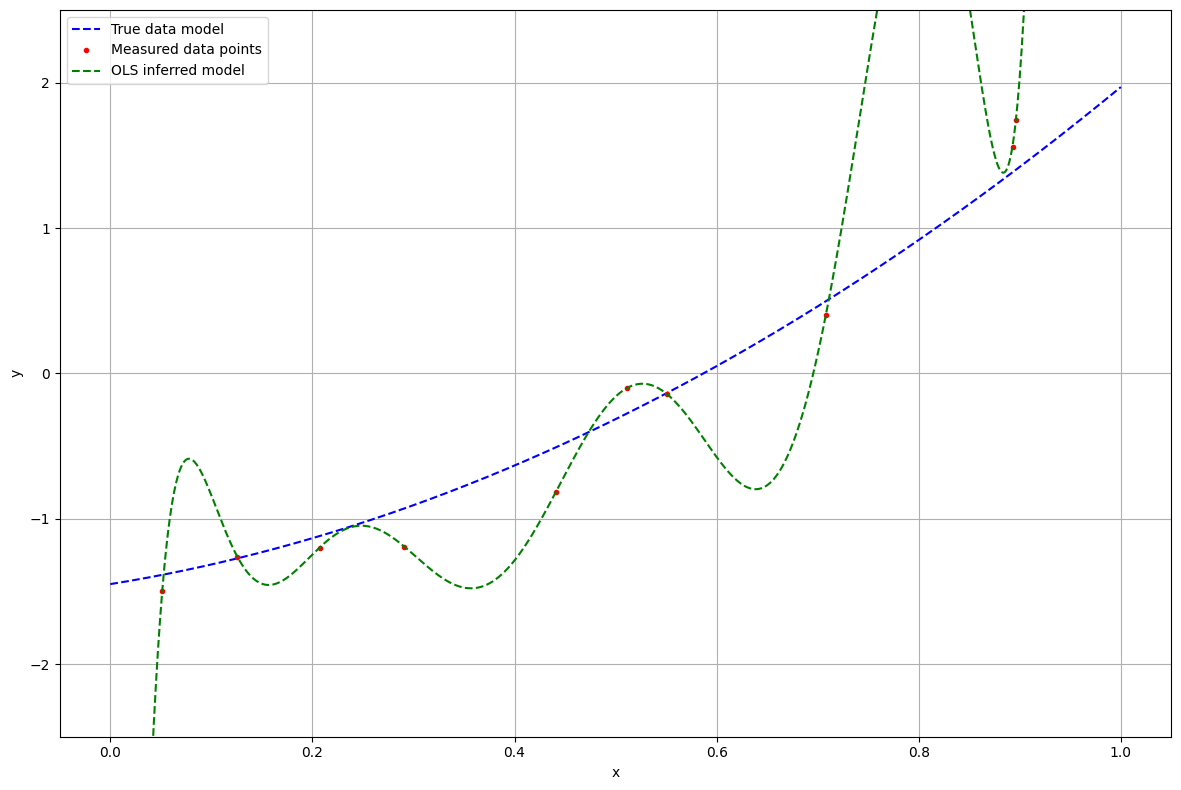

In [52]:
### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Measured data points')
plt.plot(x_highres, poly_model(x_highres, beta_ols_ho), color='g', ls='--', label='OLS inferred model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-2.5,2.5])
plt.show()

In [54]:
### Train and test loss
# Evaluate the average train MSE
y_train_ols = poly_model(x_train, beta_ols_ho)
train_loss = np.mean((y_train_ols - y_train)**2)
print('Train loss:', train_loss)

# Evaluate the average test loss
y_test_ols = poly_model(x_test, beta_ols_ho)
test_loss = np.mean((y_test_ols - y_test)**2)
print('Test loss:', test_loss)

# You can appreciate that the train error is like 0.00000.. something
# While the test error is around 15, so we have an extremely large overfitting!!!

[[1.00000000e+00 5.50797903e-01 3.03378329e-01 1.67100148e-01
  9.20384108e-02 5.06945636e-02 2.79224593e-02 1.53796320e-02
  8.47106906e-03 4.66584707e-03]
 [1.00000000e+00 7.08147823e-01 5.01473339e-01 3.55117253e-01
  2.51475509e-01 1.78081834e-01 1.26108263e-01 8.93032921e-02
  6.32399318e-02 4.47832200e-02]
 [1.00000000e+00 2.90904739e-01 8.46255671e-02 2.46179785e-02
  7.16148661e-03 2.08331039e-03 6.06044866e-04 1.76301323e-04
  5.12868905e-05 1.49195995e-05]
 [1.00000000e+00 5.10827605e-01 2.60944842e-01 1.33297829e-01
  6.80922107e-02 3.47833809e-02 1.77683112e-02 9.07654385e-03
  4.63654916e-03 2.36847730e-03]
 [1.00000000e+00 8.92946954e-01 7.97354263e-01 7.11995061e-01
  6.35773821e-01 5.67712297e-01 5.06936967e-01 4.52667821e-01
  4.04208352e-01 3.60936617e-01]
 [1.00000000e+00 8.96293089e-01 8.03341301e-01 7.20029256e-01
  6.45357246e-01 5.78429240e-01 5.18442130e-01 4.64676098e-01
  4.16485975e-01 3.73293501e-01]
 [1.00000000e+00 1.25585310e-01 1.57716702e-02 1.98069010e

This is a typical case of **overfitting**. We are trying to fit a model that is much more complex than the real one.

As you can see, the polynomial coefficients found are very large.

To alleviate this effect, we can include a **regularization** term, which penalizes coefficients with large (quadratic) values.

---

*NOTE*

We are considering an L2 regularization (quadratic penalty term), which has an analitical solution.

We can also consider the absolute values of the coefficient in the regularization term (L1 regularization).

### Regularized Least Squares (RLS) - Model unknown


Let's fit the same model as before, but with a regularization term of $0.1$.

In [56]:
### Fit the model with a higher order polynomial
beta_rls = least_squares(x_train, y_train, pol_order=9, reg_term=0.1)

print('True parameters', beta_true)
print('Inferred parameters', beta_rls)

(10,)
True parameters [-1.45, 1.12, 2.3]
Inferred parameters [-1.40193978  1.11945046  1.00587865  0.69763917  0.46265449  0.31011377
  0.21529531  0.15648382  0.11926821  0.09488916]


[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 1.00100100e-03 1.00200300e-06 ... 1.00702808e-21
  1.00803612e-24 1.00904517e-27]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06 ... 1.28899595e-19
  2.58057247e-22 5.16631125e-25]
 ...
 [1.00000000e+00 9.97997998e-01 9.96000004e-01 ... 9.86069874e-01
  9.84095760e-01 9.82125598e-01]
 [1.00000000e+00 9.98998999e-01 9.97999000e-01 ... 9.93014000e-01
  9.92019992e-01 9.91026979e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


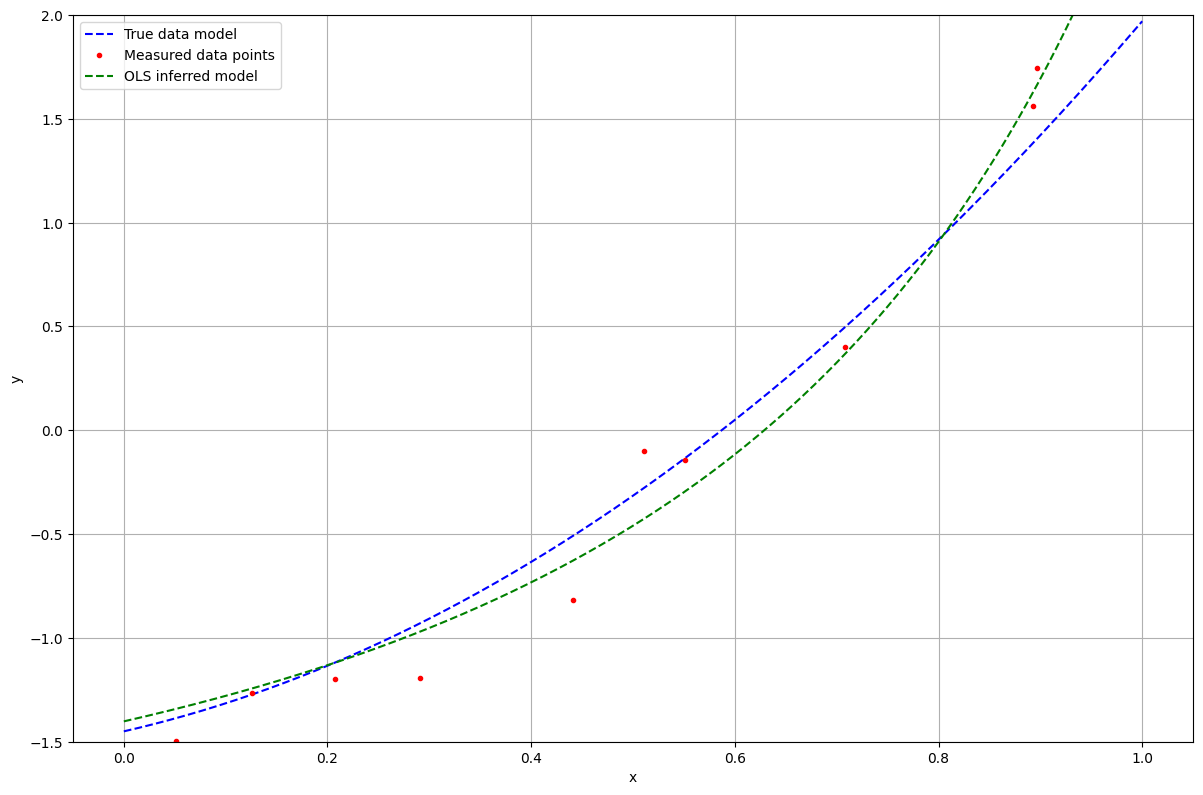

In [57]:
### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Measured data points')
plt.plot(x_highres, poly_model(x_highres, beta_rls), color='g', ls='--', label='OLS inferred model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim([-1.5,2])
plt.show()

In [58]:
### Train and test loss
# Evaluate the average train MSE
y_train_ols = poly_model(x_train, beta_rls)
train_loss = np.mean((y_train_ols - y_train)**2)
print('Train loss:', train_loss)

# Evaluate the average test loss
y_test_ols = poly_model(x_test, beta_rls)
test_loss = np.mean((y_test_ols - y_test)**2)
print('Test loss:', test_loss)

[[1.00000000e+00 5.50797903e-01 3.03378329e-01 1.67100148e-01
  9.20384108e-02 5.06945636e-02 2.79224593e-02 1.53796320e-02
  8.47106906e-03 4.66584707e-03]
 [1.00000000e+00 7.08147823e-01 5.01473339e-01 3.55117253e-01
  2.51475509e-01 1.78081834e-01 1.26108263e-01 8.93032921e-02
  6.32399318e-02 4.47832200e-02]
 [1.00000000e+00 2.90904739e-01 8.46255671e-02 2.46179785e-02
  7.16148661e-03 2.08331039e-03 6.06044866e-04 1.76301323e-04
  5.12868905e-05 1.49195995e-05]
 [1.00000000e+00 5.10827605e-01 2.60944842e-01 1.33297829e-01
  6.80922107e-02 3.47833809e-02 1.77683112e-02 9.07654385e-03
  4.63654916e-03 2.36847730e-03]
 [1.00000000e+00 8.92946954e-01 7.97354263e-01 7.11995061e-01
  6.35773821e-01 5.67712297e-01 5.06936967e-01 4.52667821e-01
  4.04208352e-01 3.60936617e-01]
 [1.00000000e+00 8.96293089e-01 8.03341301e-01 7.20029256e-01
  6.45357246e-01 5.78429240e-01 5.18442130e-01 4.64676098e-01
  4.16485975e-01 3.73293501e-01]
 [1.00000000e+00 1.25585310e-01 1.57716702e-02 1.98069010e

The result is much better! Keep in mind that we are fitting a polynomial model of **order 9** with data generated by a polynomial model of **order 2** , still achieving good results.

## The generalization problem

But what happens if we extend the model just trained outside the range of the training points?

Let's try.

[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06]
 [1.00000000e+00 4.00400400e-03 1.60320481e-05]
 ...
 [1.00000000e+00 1.99599600e+00 3.98400002e+00]
 [1.00000000e+00 1.99799800e+00 3.99199600e+00]
 [1.00000000e+00 2.00000000e+00 4.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 2.00200200e-03 4.00801202e-06 ... 1.28899595e-19
  2.58057247e-22 5.16631125e-25]
 [1.00000000e+00 4.00400400e-03 1.60320481e-05 ... 1.64991481e-17
  6.60626552e-20 2.64515136e-22]
 ...
 [1.00000000e+00 1.99599600e+00 3.98400002e+00 ... 1.26216944e+02
  2.51928515e+02 5.02848306e+02]
 [1.00000000e+00 1.99799800e+00 3.99199600e+00 ... 1.27105792e+02
  2.53957118e+02 5.07405813e+02]
 [1.00000000e+00 2.00000000e+00 4.00000000e+00 ... 1.28000000e+02
  2.56000000e+02 5.12000000e+02]]


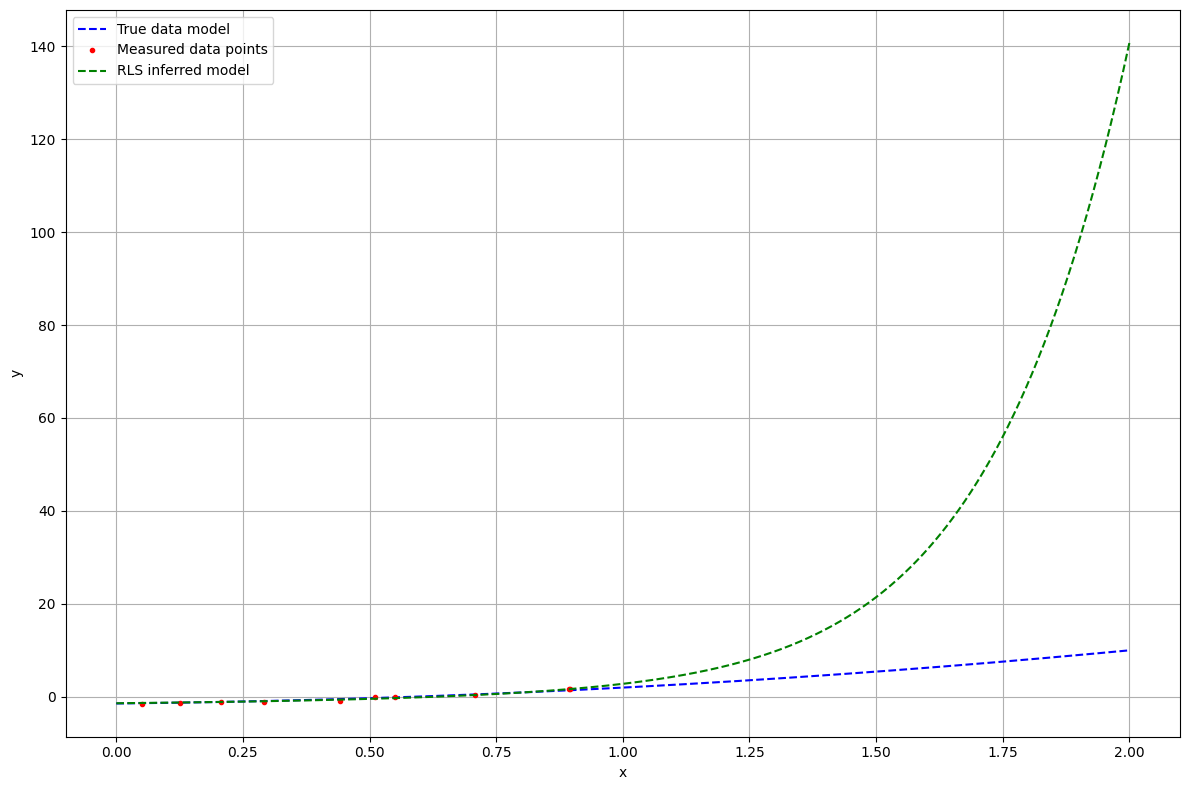

In [59]:
### Plot
plt.close('all')
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,2,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Measured data points')
plt.plot(x_highres, poly_model(x_highres, beta_rls), color='g', ls='--', label='RLS inferred model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

As you can see, the further we are from the region where we have training data, the worse the trained model approximates the true one. The inferred model does not **generalize** well outside the training space.

Typically, simpler models generalize better than complex models. When two models perform the same, the best option is (almost) always to choose the simplest of the two.

## Parameter optimization

In the previous training we used a regularization term $\alpha=0.1$. But how we choose this type of parameters?

Most machine learning/deep learning algorithms have several hyper-parameters that considerably affect the results. To find a good set of hyper-parameters we need an additional set of data, referred to as **validation** data. Hyper-parameters are typically chosen by minimizing the error on the validation set (or better by performing a cross-validation).

**TO SUMMARIZE:**

*   **Always divide your dataset in a training set and a test set.**
*   **Further divide your training set to have a validation set for hyper-parameter optimization (or perform a cross-validation)**
*   **Never touch the test set during the optimization (this is cheating!). It can be used only at the end for the final test.**



# Part 2: Least Squares with PyTorch

We will now solve the same problem, however, instead of computing the solution using the closed form equation, we wil cast this problem as a regression task and we will solve it using a simple Neural Network implemented in PyTorch.

## Data generation

Let's generate some data with our usual polynomial model, and save the data points in two csv files, one for training (train_data.csv), and one for validation (val_data.csv).

You can find these files in the "Files" section of Colab, in the "content" folder. They are not stored in your local machine, but they are stored remotely in the Colab server.

In [ ]:
def poly_model(x, beta, noise_std=0):
    """
    INPUT
        x: x vector
        beta: polynomial parameters
        noise_std: enable noisy sampling (gaussian noise, zero mean, noise_std std)
    """
    pol_order = len(beta)
    x_matrix = np.array([x**i for i in range(pol_order)]).transpose()
    y = np.matmul(x_matrix, beta)
    noise = np.random.randn(len(y)) * noise_std
    return y + noise

beta_true = [-1.45, 1.12, 2.3]
noise_std = 0.2
np.random.seed(4)

### Train data
num_train_points = 20
x_train = np.random.rand(num_train_points)
y_train = poly_model(x_train, beta_true, noise_std)
with open('train_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_train, y_train)]
    f.write('\n'.join(data))

### Validation data
num_val_points = 20
x_val = np.random.rand(num_val_points)
y_val = poly_model(x_val, beta_true, noise_std)
with open('val_data.csv', 'w') as f:
    data = [f"{x},{y}" for x, y in zip(x_val, y_val)]
    f.write('\n'.join(data))


### Plot
plt.figure(figsize=(12,8))
x_highres = np.linspace(0,1,1000)
plt.plot(x_highres, poly_model(x_highres, beta_true), color='b', ls='--', label='True data model')
plt.plot(x_train, y_train, color='r', ls='', marker='.', label='Train data points')
plt.plot(x_val, y_val, color='g', ls='', marker='.', label='Validation data points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Network Definition

Define a fully connected feed-forward network with 2 hidden layers.

Use a sigmoid activation function.

Since this is a regression, we do not want to limit the value of the output. For this reason, NO activation function should be used for the output layer.

In [ ]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        ###################################################
        ### PUT YOR CODE HERE
        self.fc1 = None
        self.fc2 = None
        self.out = None
        self.act = None
        ###################################################

    def forward(self, x, additional_out=False):
        ###################################################
        ### PUT YOR CODE HERE
        # don't forget the activations: not incuded by default!
        x = None
        ###################################################
        return x

## Dataset and Dataloader


We have already implemented the dataset class in the previous lab.

### Dataset

In [ ]:
class CsvDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        # Read the file and split the lines in a list
        with open(csv_file, 'r') as f:
            lines = f.read().split('\n')
        # Get x and y values from each line and append to self.data
        self.data = []
        for line in lines:
            sample = line.split(',')
            self.data.append((float(sample[0]), float(sample[1])))
        # Now self.data contains all our dataset.
        # Each element of the list self.data is a tuple: (input, output)

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

### Transforms

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [ ]:
composed_transform = transforms.Compose([ToTensor()])

train_dataset = CsvDataset('train_data.csv', transform=composed_transform)
val_dataset = CsvDataset('val_data.csv', transform=composed_transform)

### Dataloader

For the dataloader:

* enable the shuffling only for training data
* try different values for batch size
* disable the multiprocessing

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

## Training loop

Now we put together all the steps analyzed in the previous lab:

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

In [ ]:
# Initialize the network
torch.manual_seed(0)
Ni = 1
Nh1 = 128
Nh2 = 256
No = 1
net = Net(Ni, Nh1, Nh2, No)
net.to(device)

In [ ]:
# Define the loss function
loss_fn = nn.MSELoss()

In [ ]:
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
num_epochs = 3000
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    net.train() # Training mode (e.g. enable dropout, batchnorm updates,...)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        ###########################################
        ### PUT YOUR CODE HERE
        # Forward pass
        out = None

        # Compute loss
        loss = None

        # Backpropagation
        None

        # Update the weights
        None
        ###########################################

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout, batchnorm,...)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            ###########################################
            ### PUT YOUR CODE HERE
            # Forward pass
            out = None

            # Compute loss
            loss = None
            ###########################################

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)


        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)


### Plot losses

Additional tool for visualization:

*   [Weights and Biases](https://wandb.ai/site) (Suggested)
*   [Tensorboard](https://www.tensorflow.org/tensorboard?hl=it)



In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Network output

In [ ]:
# Input vector
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
# eval() acts as switch for some specific layers/parts of the model that behave
# differently during training and inference (eval) time. For example, Dropout
# BatchNorm etc.
net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

In [ ]:
# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we predict outside the range?

In [ ]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector
print(f"Input shape: {x_vec.shape}")

# Network output
net.eval()
with torch.no_grad():
    y_vec = net(x_vec)
print(f"Output shape: {y_vec.shape}")

# Expected output
beta_true = [-1.45, 1.12, 2.3]
true_model = poly_model(x_vec.cpu().numpy(), beta_true).squeeze()

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

# Plot output
plt.figure(figsize=(12,8))
plt.plot(x_vec, y_vec, label='Network output')
plt.plot(x_vec, true_model, label='True model')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

### What if we try different activation functions? (e.g., ReLU for nonlinearities)
### Is there overfit with ReLU?

### Homework : add some regularization to fight overfitting (e.g., dropout, weight decay,...)

## Access network parameters

In [ ]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()

## Weights histogram

In [ ]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

#### Homework (simple): compare the histogram before and after the training

## Saving the network weights **(Essential for the Final Project)**

After training a model, a good practice is to save its weights in order to be able to retrieve it later.

**NOTE**: saving the weights is essential also for creating checkpoints of your training process. Google Colab imposes time limits on your kernel sessions, so *it will not be possible for you to carry out very long training sessions*.

It will be therefore essential for your final project to create checkpoints, so that you will be able to resume your training at a later moment, when re-gaining access of your Colab runtime. Even when using a dedicated GPU in your local machine or on a server, creating checkpoints is a good practice you should always implement in your training pipeline.

### Save network

In [ ]:
### Save network parameters
### Save the network state
# The state dictionary includes all the parameters of the network
net_state_dict = net.state_dict()
print(net_state_dict.keys())
# Save the state dict to a file
torch.save(net_state_dict, 'net_parameters.torch')

### Load network

In [ ]:
### Reload the network state
# First initialize the network (if not already done)
# IMPORTANT: you need to know the model definition!!
net = Net(Ni, Nh1, Nh2, No)
# Load the state dict previously saved
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
net.load_state_dict(net_state_dict)

### Save optimizer state
Also the optimizer has its internal state!

You need to save both the network and the optimizer states if you want to continue your training.

If you are sure you have finished your training you can just save the network.

In [ ]:
### Save the optimizer state
torch.save(optimizer.state_dict(), 'optimizer_state.torch')

### Reload the optimizer state
optimizer = optim.Adam(net.parameters(), lr=0.001)
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

## Analyze activations (Advanced)

In [ ]:
# First naive way: simply change the network definition to return an additional output

# More advanced strategy (optional if you're not familiar with Python!): using hooks

def get_activation(layer, input, output):
    global activation
    activation = torch.sigmoid(output)

### Register hook
hook_handle = net.fc2.register_forward_hook(get_activation)

### Analyze activations
net = net.to(device)
net.eval()
with torch.no_grad():
    x1 = torch.tensor([0.1]).float().to(device)
    y1 = net(x1)
    z1 = activation
    x2 = torch.tensor([0.9]).float().to(device)
    y2 = net(x2)
    z2 = activation
    x3 = torch.tensor([2.5]).float().to(device)
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))
axs[0].stem(z1.cpu().numpy())
axs[0].set_title('Last layer activations for input x=%.2f' % x1)
axs[1].stem(z2.cpu().numpy())
axs[1].set_title('Last layer activations for input x=%.2f' % x2)
axs[2].stem(z3.cpu().numpy())
axs[2].set_title('Last layer activations for input x=%.2f' % x3)
plt.tight_layout()
plt.show()

# Part 3: Classification model with PyTorch


**HINTS**
- Choose a loss function that is suitable for the specific problem, a binary classification in this case. If you keep a single linear output you can use a BCEWithLogitsLoss, which is more numerically stable than manually using a sigmoid output activation (more info here: https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html ).
- The network now has 2 inputs. A batched input should have a shape $\text{batch_size} \times 2$.
- The dataset should be adapted accordingly. Also consider to increase the batch size.
- Explore different optimizers, trying to understand the differences and their parameters (https://pytorch.org/docs/stable/optim.html ).
- Try to increase the complexity of the network, and at the same time to introduce some regularization with dropout layers and/or weight decay (which is equivalent to an L2 regularization, typically implemented by the optimizer).
- Experiment with different hyper-parameters trying to minimize the VALIDATION LOSS. Once you are happy with the result, try the final test with the TEST dataset.

## Data generation

In [ ]:
import itertools

np.random.seed(123)

def bidimensional_model(x1, x2):
    a = 1
    b = 1
    cx1 = 0
    cx2 = 0
    out = (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 1
    b = 2
    cx1 = -2.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 1
    cx1 = -6
    cx2 = -2.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 4
    cx1 = -7.5
    cx2 = -5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 6
    b = 1
    cx1 = -7.5
    cx2 = 5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 4
    b = 4
    cx1 = 7.5
    cx2 = -7.5
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 3
    b = 2
    cx1 = -1
    cx2 = -6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 5
    cx1 = 1
    cx2 = 6
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    a = 2
    b = 2
    cx1 = 6
    cx2 = 0
    out |= (x1 - cx1)**2 / a**2 + (x2 - cx2)**2 / b **2 < 1
    return out.astype(int)

### PLOT MODEL
# Input grid
x1 = np.linspace(-10, 10, 400)
x2 = np.linspace(-10, 10, 400)
x_prod = [x for x in itertools.product(x1, x2)]
x1 = np.array([x[0] for x in x_prod])
x2 = np.array([x[1] for x in x_prod])
# Evaluate out
y = bidimensional_model(x1, x2)
# Scatter plot
fig, ax = plt.subplots(figsize=(12,8))
colors = np.array(['C0', 'C1'])
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.show()

### Training points

In [ ]:
import pandas as pd

### Train data
num_points = 1000
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
train_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
train_df.to_csv('classifier_train_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Training points')
fig.show()

### Validation points

In this case: we generate validation points.
Usually: validation points are randomly selected from the training points (~20% of training data).

In [ ]:
### Validation data
num_points = 200
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_val_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Validation points')
fig.show()

### Test points

In [ ]:
### Test data
num_points = 400
x1 = np.random.uniform(-10, 10, num_points)
x2 = np.random.uniform(-10, 10, num_points)
y = bidimensional_model(x1, x2)
val_df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
val_df.to_csv('classifier_test_data.csv', index=False)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x1, x2, c=colors[y], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Test points')
fig.show()

## Dataset and Dataloader

Define the dataset

In [ ]:
class ClassifierDataset(Dataset):

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        ###############################
        # PUT YOUR CODE HERE
        self.transform = None
        # Read the file and store the content in a pandas DataFrame
        self.df = None
        ###############################

    def __len__(self):
        ###############################
        # PUT YOUR CODE HERE
        # The length of the dataset is simply the length of the self.df DataFrame
        return None
        ###############################

    def __getitem__(self, idx):
        # Our sample is the row at index idx of the dataframe

        ###############################
        # PUT YOUR CODE HERE
        row = self.df.iloc[idx]
        # There are 2 inputs this time
        sample = ([row.x1, row.x2], row.y)
        if self.transform:
            sample = None
        ###############################
        return sample

Define the transformations

In [ ]:
class ToTensor(object):
    """Convert sample to Tensors."""

    def __call__(self, sample):
        x, y = sample
        return (torch.Tensor(x).float(),
                torch.Tensor([y]).float())

Initialize the datasets

In [ ]:
###############################
### PUT YOUR CODE HERE
composed_transform = transforms.Compose([ToTensor()])

train_dataset = None
val_dataset   = None
test_dataset  = None
###############################

Define the dataloaders

In [ ]:
###############################
#Put your code here
train_dataloader = None #batch size = 200
val_dataloader   = None #The batch size can be equal to the validation set size if it fits in memory
test_dataloader  = None
###############################

## Network definition

In [ ]:
class Net(nn.Module):

    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()

    def forward(self, x, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.out(x)
        return x

## Training loop

In [ ]:
# Initialize the network
torch.manual_seed(0)
Ni = 2
Nh1 = 128
Nh2 = 256
No = 1 #now we have classification between two classes

net = Net(Ni, Nh1, Nh2, No)
net.to(device)

# Define the loss function
###############################################
###PUT YOUR CODE HERE
loss_fn = None # TODO: use a proper classification loss

# Define the optimizer with lr=1e-2
optimizer = None
###############################################

In [ ]:
### TRAINING LOOP
num_epochs = 600
train_loss_log = []
val_loss_log = []
for epoch_num in range(num_epochs):
    print('#################')
    print(f'# EPOCH {epoch_num}')
    print('#################')

    ### TRAIN
    train_loss= []
    ###############################################
    ###PUT YOUR CODE HERE
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
        # Move data to device
        x_batch = None
        label_batch = None

        # Forward pass
        out = None

        # Compute loss
        loss = None

        # Backpropagation
        None

        # Update the weights
        None

        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)

    # Save average train loss
    train_loss = np.mean(train_loss)
    print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_loss_log.append(train_loss)

    ### VALIDATION
    val_loss= []
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader:
            # Move data to device
            x_batch = None
            label_batch = None

            # Forward pass
            out=None

            # Compute loss
            loss = None

            # Save val loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            val_loss.append(loss_batch)
        ###############################################
        # Save average validation loss
        val_loss = np.mean(val_loss)
        print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
        val_loss_log.append(val_loss)


In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

## Final test

Iterate the dataloader a single time and save all the outputs (in case you have multiple batches)

In [ ]:
all_inputs = []
all_outputs = []
all_labels = []
net.eval() # Evaluation mode (e.g. disable dropout)
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)
        # Forward pass
        out = net(x_batch)
        # Save outputs and labels
        all_inputs.append(x_batch)
        all_outputs.append(out)
        all_labels.append(label_batch)
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)

test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

In this case the network has a linear output (for a better stability of the loss function).
To have probability estimates you can apply a sigmoid to the network output.

Since we just need the most probable class and we have a single output, we can consider the sign of the linear output. Negative output means that the class 0 is the most probable (probability < 50%), otherwise class 1 (probability > 50%).

Essentially this network estimates the probability of the input sample to be of class 1.

> **NOTE**
>
> You can (and should, for practice) redefine the problem by defining a network with more than one output, each of them corresponding to a specific class (2 in this case). Since the two classes are mutually exclusive, the loss function should be a CrossEntropyLoss (softmax activation). In a multi-class scenario, a BCE loss is suitable when the classes are NOT mutually exclusive.






---


Get the most probable class inferred by the network


In [ ]:
# Get the most probable class inferred by the network
all_output_classes = torch.zeros(all_outputs.shape).to(device)
all_output_classes[all_outputs > 0] = 1

Evaluate the test accuracy

In [ ]:
tot_correct_out = (all_output_classes == all_labels).sum()
test_accuracy = 100 * tot_correct_out / len(all_labels)
print(f"TEST ACCURACY: {test_accuracy:.2f}%")

In [ ]:
len(all_output_classes)

Plot the results

In [ ]:
### Plot
x1 = all_inputs.squeeze().cpu().numpy()[:, 0]
x2 = all_inputs.squeeze().cpu().numpy()[:, 1]
y_true = all_labels.squeeze().cpu().numpy()
y_pred = all_output_classes.squeeze().cpu().numpy()

fig, ax = plt.subplots(figsize=(12,8))
# Plot predictions
ax.scatter(x1, x2, c=colors[y_pred.astype(np.uint8)], s=10, marker='o')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Network Predictions')
# Mark wrong outputs
error_mask = y_pred != y_true
ax.scatter(x1[error_mask], x2[error_mask], color='red', s=100, marker='x', label='MISCLASSIFIED SAMPLES')
plt.legend()
fig.show()

# (Optional) High-level and Lightweight PyTorch wrapper: PyTorch Lightning


Lightning forces the following structure to your code which makes it reusable and shareable:

Research code (the LightningModule).
Engineering code (you delete, and is handled by the Trainer).
Non-essential research code (logging, etc... this goes in Callbacks).
Data (use PyTorch DataLoaders or organize them into a LightningDataModule).
Once you do this, you can train on multiple-GPUs, TPUs, CPUs and even in 16-bit precision without changing your code!

In [ ]:
! pip install pytorch-lightning

import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [ ]:
# Define a LightningModule (nn.Module subclass)
# A LightningModule defines a full system (ie: a GAN, autoencoder, BERT or a simple Image Classifier).
class LitNet(pl.LightningModule):
    def __init__(self, Ni, Nh1, Nh2, No):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()

        print('Network initialized')
        self.net = nn.Sequential(nn.Linear(in_features=Ni, out_features=Nh1),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh1, out_features=Nh2),
                       nn.Sigmoid(),
                       nn.Linear(in_features=Nh2, out_features=No))
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.net(x)

    # Training_step defines the training loop.
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.train_loss.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx=None):
        # validation_step defines the validation loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.net(x_batch)
        loss = F.binary_cross_entropy_with_logits(out, label_batch)
        self.val_loss.append(loss.item())
        self.log("val_loss", loss.item(), prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.net.parameters(), lr=1e-2)
        return optimizer

In [ ]:
# TRAIN!
batch_size = 200
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader   = DataLoader(val_dataset,   batch_size=len(val_dataset), shuffle=False, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

trainer = pl.Trainer(devices=1, max_epochs=20, val_check_interval=1)
litnet = LitNet(Ni, Nh1, Nh2, No)
trainer.fit(litnet, train_dataloader, val_dataloader)


In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(litnet.train_loss, label='Train loss')
plt.semilogy(litnet.val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# (Optional) Automatic Hyper-parameters Tuning: Optuna


Optuna is an automatic hyperparameter optimization software framework.

- Lightweight, versatile, and platform agnostic architecture
- Pythonic search spaces
- Efficient optimization algorithms
- Easy parallelization
- Quick visualization


Definitions:

- Study: optimization based on an objective function
- Trial: a single execution of the objective function

The goal of a study is to find out the optimal set of hyperparameter values (e.g., classifier and svm_c) through multiple trials (e.g., n_trials=100). Optuna is a framework designed for the automation and the acceleration of the optimization studies.

Optuna works with PyTorch, but also with Tensorflow, Keras and PyTorch Lightning! (and many others)

In [ ]:
! pip install optuna

In [ ]:
# Before we used:
# Nh1 = 128
# Nh2 = 256

import optuna

def objective(trial):

    # We optimize the number of hidden units in each layer.
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 64, 256, log=True) for i in range(2)
    ]

    model = LitNet(Ni, output_dims[0], output_dims[1], No)

    trainer = pl.Trainer(devices=1, max_epochs=20, val_check_interval=1,
                         log_every_n_steps=1)
    hyperparameters = dict(output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, train_dataloader, val_dataloader)
    return trainer.callback_metrics["val_loss"].item()


pruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=3, timeout=300)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Homework

Try tuning other hyper-parameters, such as the learning rate.